#Implementazione progetto "Cybersecurity for Data Science" 
Gianmarco Russo mat.887277 Msc Data Science @Università degli studi di Milano-Bicocca

##Imports

In [55]:
!pip install cleverhans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from cleverhans.tf2.utils import optimize_linear, compute_gradient
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.2


In [57]:
from fast_gradient_method import fast_gradient_method
from projected_gradient_descent import projected_gradient_descent

In [97]:
from easydict import EasyDict

In [98]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D

In [99]:
import matplotlib.pyplot as plt

##Adversarial input

In [100]:
def ld_mnist():
    """Load training and test data."""

    def convert_types(image, label):
        image = tf.cast(image, tf.float32)
        image /= 255
        return image, label

    dataset, info = tfds.load(
        "mnist", data_dir="gs://tfds-data/datasets", with_info=True, as_supervised=True
    )
    mnist_train, mnist_test = dataset["train"], dataset["test"]
    mnist_train = mnist_train.map(convert_types).shuffle(10000).batch(128)
    mnist_test = mnist_test.map(convert_types).batch(128)
    return EasyDict(train=mnist_train, test=mnist_test)

In [101]:
class Net(Model):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = Conv2D(64, 8, strides=(2, 2), activation="relu", padding="same")
        self.conv2 = Conv2D(128, 6, strides=(2, 2), activation="relu", padding="valid")
        self.conv3 = Conv2D(128, 5, strides=(1, 1), activation="relu", padding="valid")
        self.dropout = Dropout(0.25)
        self.flatten = Flatten()
        self.dense1 = Dense(128, activation="relu")
        self.dense2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)

In [102]:
data = ld_mnist()
model=Net()
loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam(learning_rate=0.001)

In [103]:
epochs=5

In [104]:
train_loss = tf.metrics.Mean(name="train_loss")
test_acc_clean = tf.metrics.SparseCategoricalAccuracy()
test_acc_fgsm = tf.metrics.SparseCategoricalAccuracy()
test_acc_pgd = tf.metrics.SparseCategoricalAccuracy()

In [105]:
for epoch in range(epochs):
  for (x, y) in data.train:
    x = fast_gradient_method(model, x, 0.1, np.inf)

In [106]:
for x, y in data.test:
  y_pred = model(x)
  test_acc_clean(y, y_pred)

  x_fgm = fast_gradient_method(model, x, 0.1, np.inf)
  y_pred_fgm = model(x_fgm)
  test_acc_fgsm(y, y_pred_fgm)

  x_pgd = projected_gradient_descent(model, x, 0.1, 0.01, 40, np.inf)
  y_pred_pgd = model(x_pgd)
  test_acc_pgd(y, y_pred_pgd)

In [107]:
print("test acc on clean examples (%): {:.3f}".format(test_acc_clean.result() * 100))
print("test acc on FGM adversarial examples (%): {:.3f}".format(test_acc_fgsm.result() * 100))
print("test acc on PGD adversarial examples (%): {:.3f}".format(test_acc_pgd.result() * 100))

test acc on clean examples (%): 11.590
test acc on FGM adversarial examples (%): 6.510
test acc on PGD adversarial examples (%): 7.220


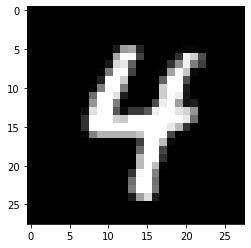

In [108]:
plt.imshow(x[0].numpy().reshape([28, 28]), cmap='gray')

In [109]:
tf.nn.softmax(y_pred[0].numpy())

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.10015729, 0.10041916, 0.10150383, 0.10006273, 0.09877273,
       0.09903377, 0.10077988, 0.10015166, 0.09882744, 0.10029154],
      dtype=float32)>

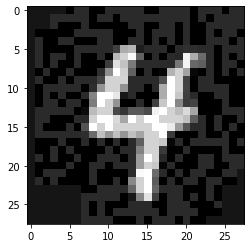

In [110]:
plt.imshow(x_fgm[0].numpy().reshape([28, 28]), cmap='gray')

In [111]:
tf.nn.softmax(y_pred_fgm[0].numpy())

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.10017508, 0.10031486, 0.0975628 , 0.10218097, 0.09828578,
       0.09963465, 0.10094686, 0.10011466, 0.10023558, 0.10054878],
      dtype=float32)>

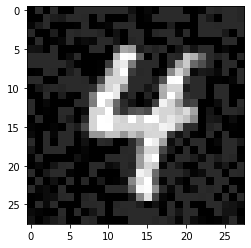

In [112]:
plt.imshow(x_pgd[0].numpy().reshape([28, 28]), cmap="gray")

In [113]:
tf.nn.softmax(y_pred_pgd[0].numpy())

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.10113785, 0.09968013, 0.09312371, 0.10477996, 0.09903461,
       0.09950064, 0.10098869, 0.0987988 , 0.10080706, 0.10214859],
      dtype=float32)>

Per fare ulteriori prove con valori diversi di $\epsilon$ runnare nuovamente i chunk qui sopra modificando i valori passati alle funzioni.

##SVD per robustezza training modello

In [114]:
from numpy import array
from scipy.linalg import svd

Prendiamo un immagine dal train set "pulito"

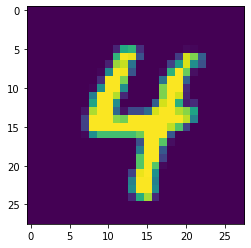

In [115]:
plt.imshow(x[0].numpy().reshape([28, 28]))

applichiamo SVD e ricontruiamo con solo i 7 valori singolari più importanti:

In [116]:
U, sigma, V = svd(x[0].numpy().reshape([28, 28]))
reconstimg = np.matrix(U[:, :7]) * np.diag(sigma[:7]) * np.matrix(V[:7, :])

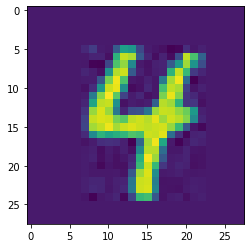

In [117]:
plt.imshow(reconstimg)

prendiamo ora un'immagine dal set modificato con FGSM e facciamo la stessa cosa:

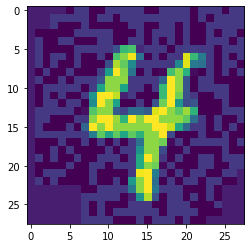

In [118]:
plt.imshow(x_fgm[0].numpy().reshape([28, 28]))

applichiamo svd:

In [119]:
U_fgm, sigma_fgm, V_fgm = svd(x_fgm[0].numpy().reshape([28, 28]))
reconstimg_fgm = np.matrix(U_fgm[:, :7]) * np.diag(sigma_fgm[:7]) * np.matrix(V_fgm[:7, :])

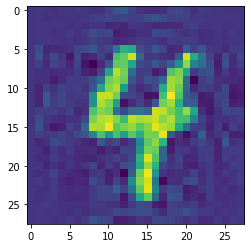

In [120]:
plt.imshow(reconstimg_fgm)

Analizziamo ora il contenuto informativo presente nei valori singolari delle due immagini:

In [127]:
sigma[:7]

array([7.4460964 , 4.223449  , 2.7801604 , 1.673495  , 1.4292104 ,
       1.1732059 , 0.68113923], dtype=float32)

In [122]:
abs(np.sum(sigma[:7]))

19.406757

In [123]:
sigma_fgm[:7]

array([7.4325347, 4.170485 , 2.856722 , 1.8649861, 1.4886585, 1.2491019,
       1.0390464], dtype=float32)

In [124]:
abs(np.sum(sigma_fgm[:7]))

20.101536

In [125]:
abs(np.sum(sigma[:7])-np.sum(sigma_fgm[:7]))

0.69477844

In [128]:
abs(np.sum(sigma)-np.sum(sigma_fgm))

6.4675484